<a href="https://colab.research.google.com/github/nerissavu/CHEG47_MLWorkshop2/blob/main/ML_Workshop_27_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap -q


import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
import joblib
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# Import filters to remove unnecessary warnings
from warnings import simplefilter
import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import ConvergenceWarning

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# Import filters to remove unnecessary warnings
from warnings import simplefilter
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.3 MB/s eta 0:00:00


In [ ]:
# Read the Excel file, skipping the first two rows
df = pd.read_excel('/content/Hydrogen storage dataset.xlsx', skiprows=2)

# Reset the index if needed
df = df.reset_index(drop=True)

# Display the first few rows to verify
print(df.head())

                                       Material name  \
0  Carbon nanotube functionalized with HNO3 at 80 °C   
1  Carbon nanotube functionalized with HNO3 at 80 °C   
2  Carbon nanotube functionalized with HNO3 at 80 °C   
3  Carbon nanotube functionalized with HNO3 at 80 °C   
4  Carbon nanotube functionalized with HNO3 at 80 °C   

   Average crystal size (nm)  Crystalinity index (%)  \
0                   3.780644               82.394903   
1                   3.780644               82.394903   
2                   3.780644               82.394903   
3                   3.780644               82.394903   
4                   3.780644               82.394903   

    BET surface area (m²/g)  Pore volume (cm³/g)  Temperature (K)  \
0                     125.2                1.018            298.0   
1                     125.2                1.018            298.0   
2                     125.2                1.018            298.0   
3                     125.2                1.018  

In [ ]:
df.dtypes

,0
Material name,object
Average crystal size (nm),float64
Crystalinity index (%),float64
BET surface area (m²/g),float64
Pore volume (cm³/g),float64
Temperature (K),float64
Pressure (bar),object
Hydrogen uptake/adsorption (wt%),float64
Hydrogen desorption (wt%),float64


Pressure suppose to be a type float => change type of pressure

In [ ]:


df['Pressure (bar)'] = pd.to_numeric(df['Pressure (bar)'], errors='coerce')

In [ ]:
df.dtypes

,0
Material name,object
Average crystal size (nm),float64
Crystalinity index (%),float64
BET surface area (m²/g),float64
Pore volume (cm³/g),float64
Temperature (K),float64
Pressure (bar),float64
Hydrogen uptake/adsorption (wt%),float64
Hydrogen desorption (wt%),float64


In [ ]:
# Check for duplicates in the entire dataset
duplicates = df.duplicated()
# If there are any duplicates, the 'duplicates' variable will contain True for those rows
if duplicates.any():
    # Get the rows with duplicates
    duplicate_rows = df[duplicates]
else:
    print("No duplicates found in the dataset.")

No duplicates found in the dataset.


In [ ]:
# check if the data contains null values, if yes, filled it with average value
df.isna().sum()
# Identify numeric and non-numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
# Fill missing values in numeric columns with their mean
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())


print(df.head())

                                       Material name  \
0  Carbon nanotube functionalized with HNO3 at 80 °C   
1  Carbon nanotube functionalized with HNO3 at 80 °C   
2  Carbon nanotube functionalized with HNO3 at 80 °C   
3  Carbon nanotube functionalized with HNO3 at 80 °C   
4  Carbon nanotube functionalized with HNO3 at 80 °C   

   Average crystal size (nm)  Crystalinity index (%)  \
0                   3.780644               82.394903   
1                   3.780644               82.394903   
2                   3.780644               82.394903   
3                   3.780644               82.394903   
4                   3.780644               82.394903   

    BET surface area (m²/g)  Pore volume (cm³/g)  Temperature (K)  \
0                     125.2                1.018            298.0   
1                     125.2                1.018            298.0   
2                     125.2                1.018            298.0   
3                     125.2                1.018  

In [ ]:
df.describe()  # Summary statistics for numerical columns

,Average crystal size (nm),Crystalinity index (%),BET surface area (m²/g),Pore volume (cm³/g),Temperature (K),Pressure (bar),Hydrogen uptake/adsorption (wt%),Hydrogen desorption (wt%)
count,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000
mean,8.166266,49.162962,258.195065,0.838367,246.267191,31.001040,0.601873,0.750073
std,4.560454,16.764251,214.466418,0.609617,152.823071,28.849595,0.652448,0.349933
min,2.977754,18.900143,39.200000,0.021000,77.000000,0.000000,0.000000,0.011229
25%,3.669600,36.381961,89.060000,0.307000,77.000000,5.797180,0.212346,0.750073
50%,9.032235,52.881608,204.000000,0.530000,298.000000,19.924000,0.528395,0.750073
75%,12.543453,62.089987,428.000000,1.410000,298.150000,50.329800,0.601873,0.750073
max,15.712170,82.394903,870.000000,1.891000,873.150000,99.751700,4.797770,3.286860


['Average crystal size (nm)', 'Crystalinity index (%)', ' BET surface area (m²/g)', 'Pore volume (cm³/g)', 'Temperature (K)', 'Pressure (bar)', 'Hydrogen uptake/adsorption (wt%)', 'Hydrogen desorption (wt%)']

Analyzing outliers in Average crystal size (nm):
Number of outliers: 0

Analyzing outliers in Crystalinity index (%):
Number of outliers: 0

Analyzing outliers in  BET surface area (m²/g):
Number of outliers: 0

Analyzing outliers in Pore volume (cm³/g):
Number of outliers: 0

Analyzing outliers in Temperature (K):
Number of outliers: 1
Outlier values:
286    873.15
Name: Temperature (K), dtype: float64

Analyzing outliers in Pressure (bar):
Number of outliers: 0

Analyzing outliers in Hydrogen uptake/adsorption (wt%):
Number of outliers: 14
Outlier values:
163    2.79327
164    3.19712
165    3.35417
252    2.79771
267    2.99586
268    3.28618
269    3.48634
270    3.89906
279    2.99859
280    3.69373
281    4.00865
282    4.10899
283    4.30905
284    4.79777
Name: Hydrogen u

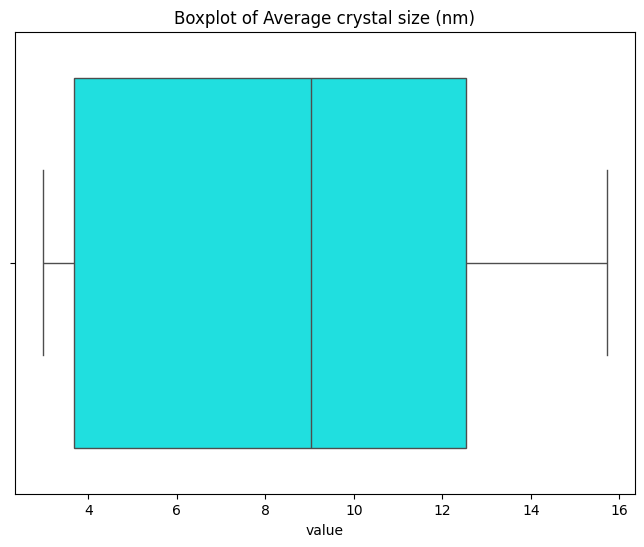

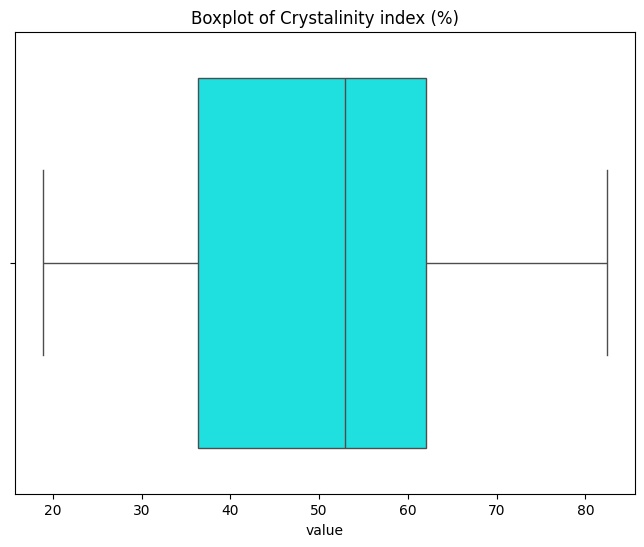

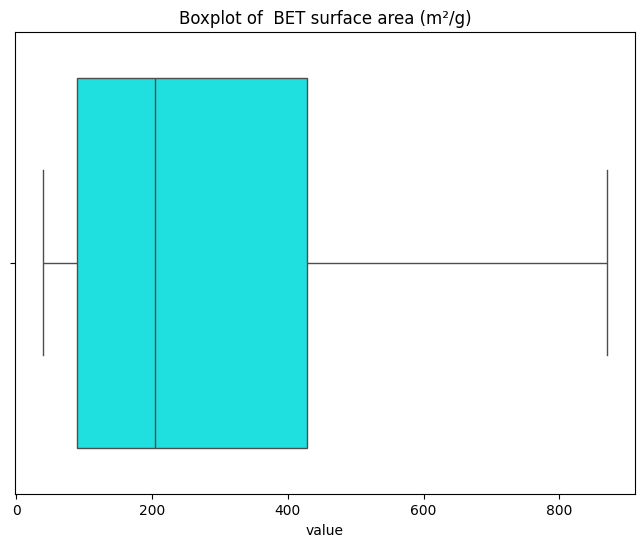

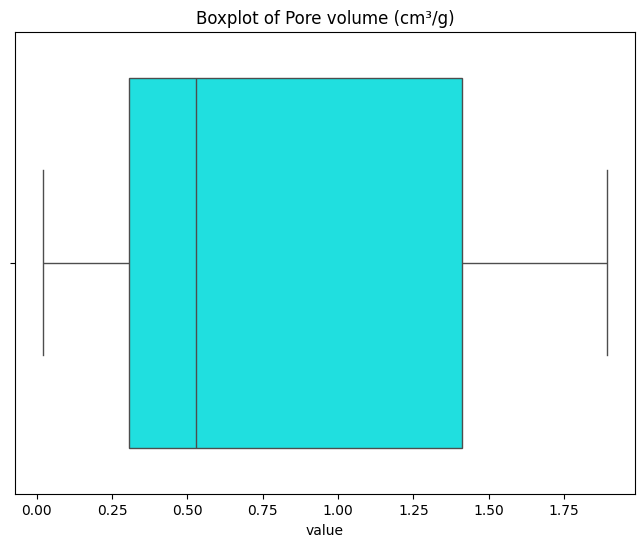

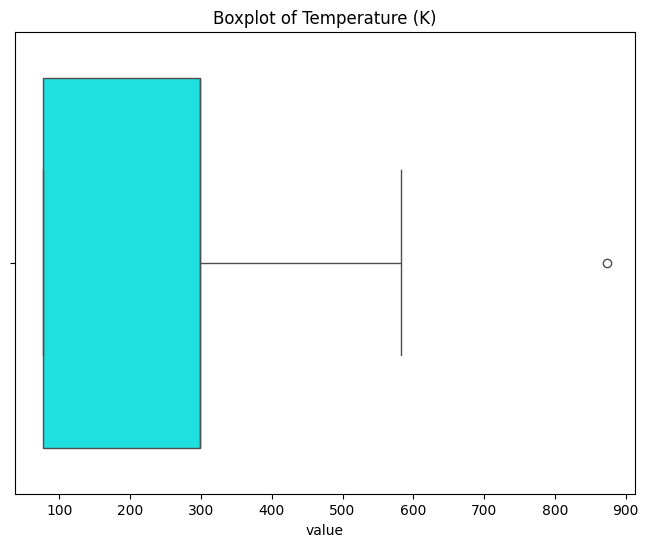

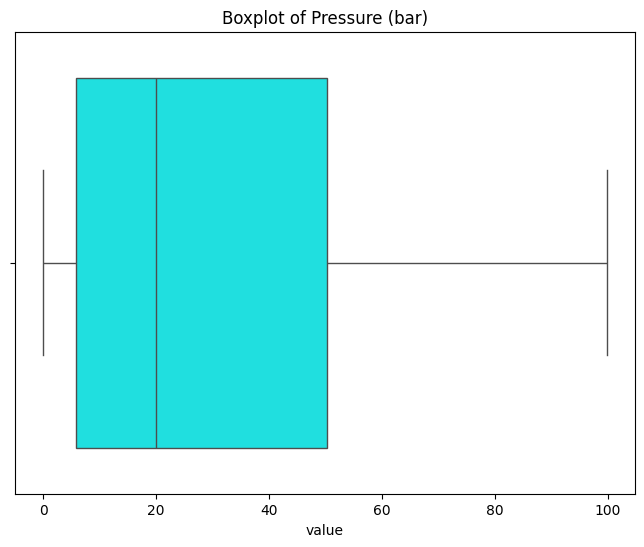

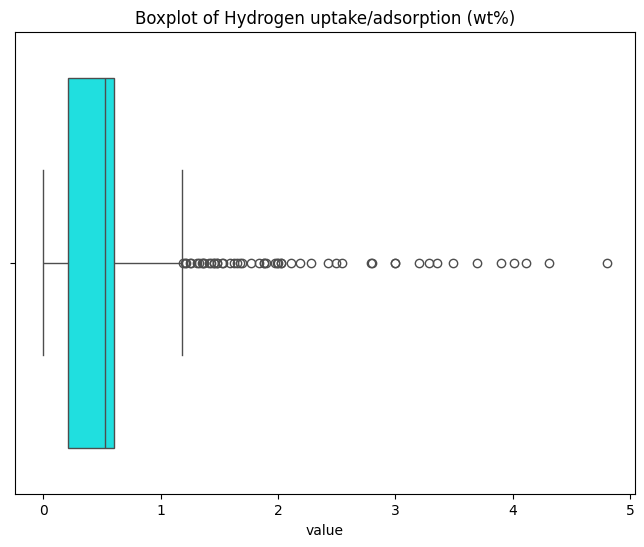

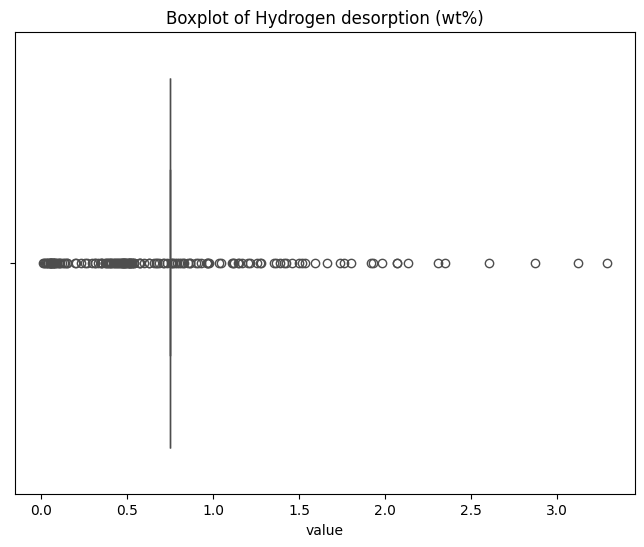

In [ ]:
# This script collect al the rows with outliers data
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
print(numeric_columns)

rows_to_remove = set()

for column in numeric_columns:
    print(f"\nAnalyzing outliers in {column}:")

    # Calculate Z-score
    z_scores = np.abs(stats.zscore(df[column]))

    # Identify outliers (Z-score > 3)
    outliers = df[z_scores > 3]

    print(f"Number of outliers: {len(outliers)}")
    if len(outliers) > 0:
        print("Outlier values:")
        print(outliers[column])
        rows_to_remove.update(outliers.index)

#Box plot
for column in numeric_columns:
    # plt.figure(figsize=(10, 6))
    # plt.title(f"Box Plot of {column}")
    # plt.boxplot(df[column])
    # plt.show()
    plt.figure(figsize=(8,6))
    sns.boxplot(x=df[column], color='cyan')
    plt.title(f"Boxplot of {column}")
    plt.xlabel('value')
    plt.show()

In [ ]:
df['Material name'].unique()

array(['Carbon nanotube functionalized with HNO3 at 80 °C',
       'Carbon nanotube functionalized with HNO3 at 100 °C',
       'Carbon nanotube functionalized with H2SO4:HNO3 at 80 °C ',
       'Carbon nanotube functionalized with H2SO4:HNO3 at 100 °C ',
       'Multi-walled carbon nanotube functionalized with H2SO4 and HNO3 with 3:1 ratio',
       'Multi-walled carbon nanotube functionalized with DMF and SOCl2 acylation ',
       'Carbon nanotube doped with Pd nanoparticle for 24 h',
       'Carbon nanotube doped with Pd nanoparticle for 48 h',
       'Carbon nanotube doped with Pd nanoparticle for 72 h',
       'SWCNT doped with Mg-Ni(Mg45w%,Ni 55w%)',
       'SWCNT doped with Mg-Ni-Cu(Mg41.2w%,Ni53.6w%,Cu6.2w%)',
       'SWCNT doped with Mg-Ni-Cu(Mg39.6w%,Ni50.3w%,Cu10.1w%)',
       'CNT decorated with Ni at mass ratio of 2',
       'CNT decorated with Ni at mass ratio of 5',
       'CNT decorated with Ni at mass ratio of 10',
       'CNT decorated with Ni at mass ratio of 20',
   

In [ ]:
df['Material name'].value_counts()

,count
Material name,
Multi-walled carbon nanotube functionalized with H2SO4 and HNO3 with 3:1 ratio,88
MWCNT loaded with Pt,80
Multi-walled carbon nanotube functionalized with DMF and SOCl2 acylation,77
CNT decorated with Ni at mass ratio of 10,50
Nitrogen-doped carbon nanorods at 500 °C (NCNR-500),29
CNT decorated with Ni at mass ratio of 2,25
CNT decorated with Ni at mass ratio of 5,24
Nitrogen-doped fused bead carbon nanotubes at 700 °C (NCBCT-700),22
Nitrogen-doped carbonnanotubes at 900 °C (NCNT-900),20


# **Data Visualization**

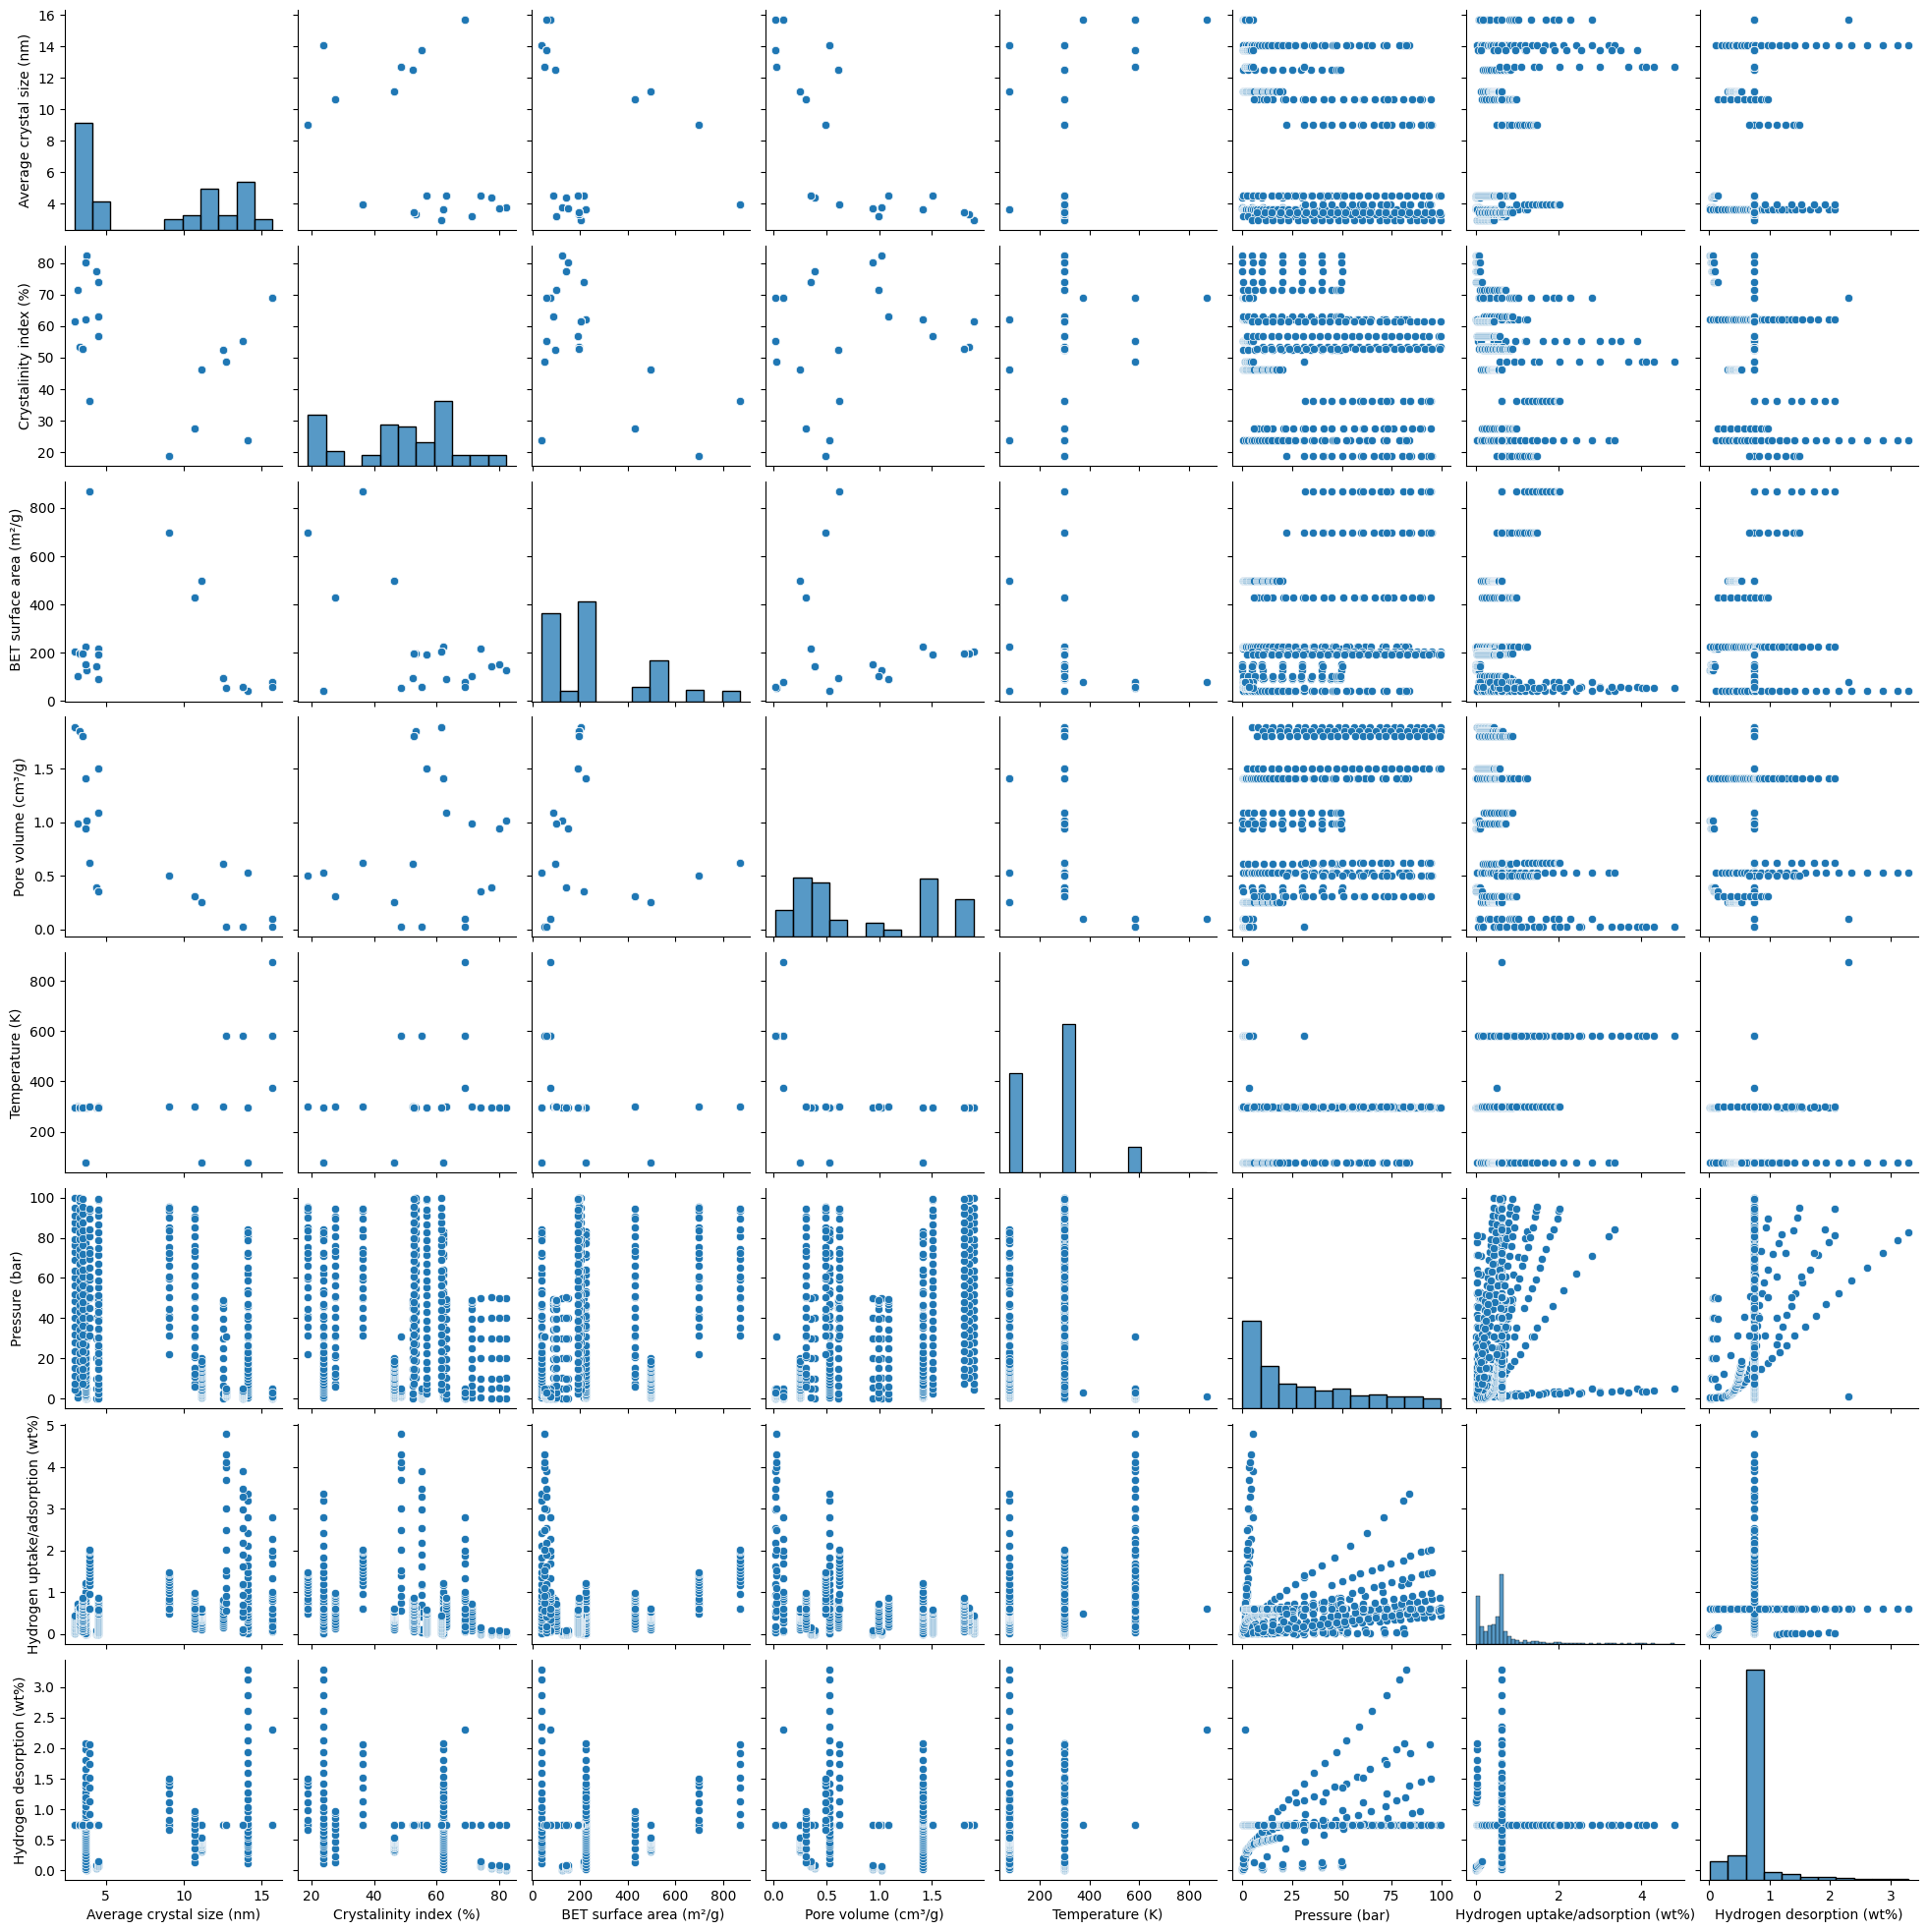

In [ ]:
sns.pairplot(df)

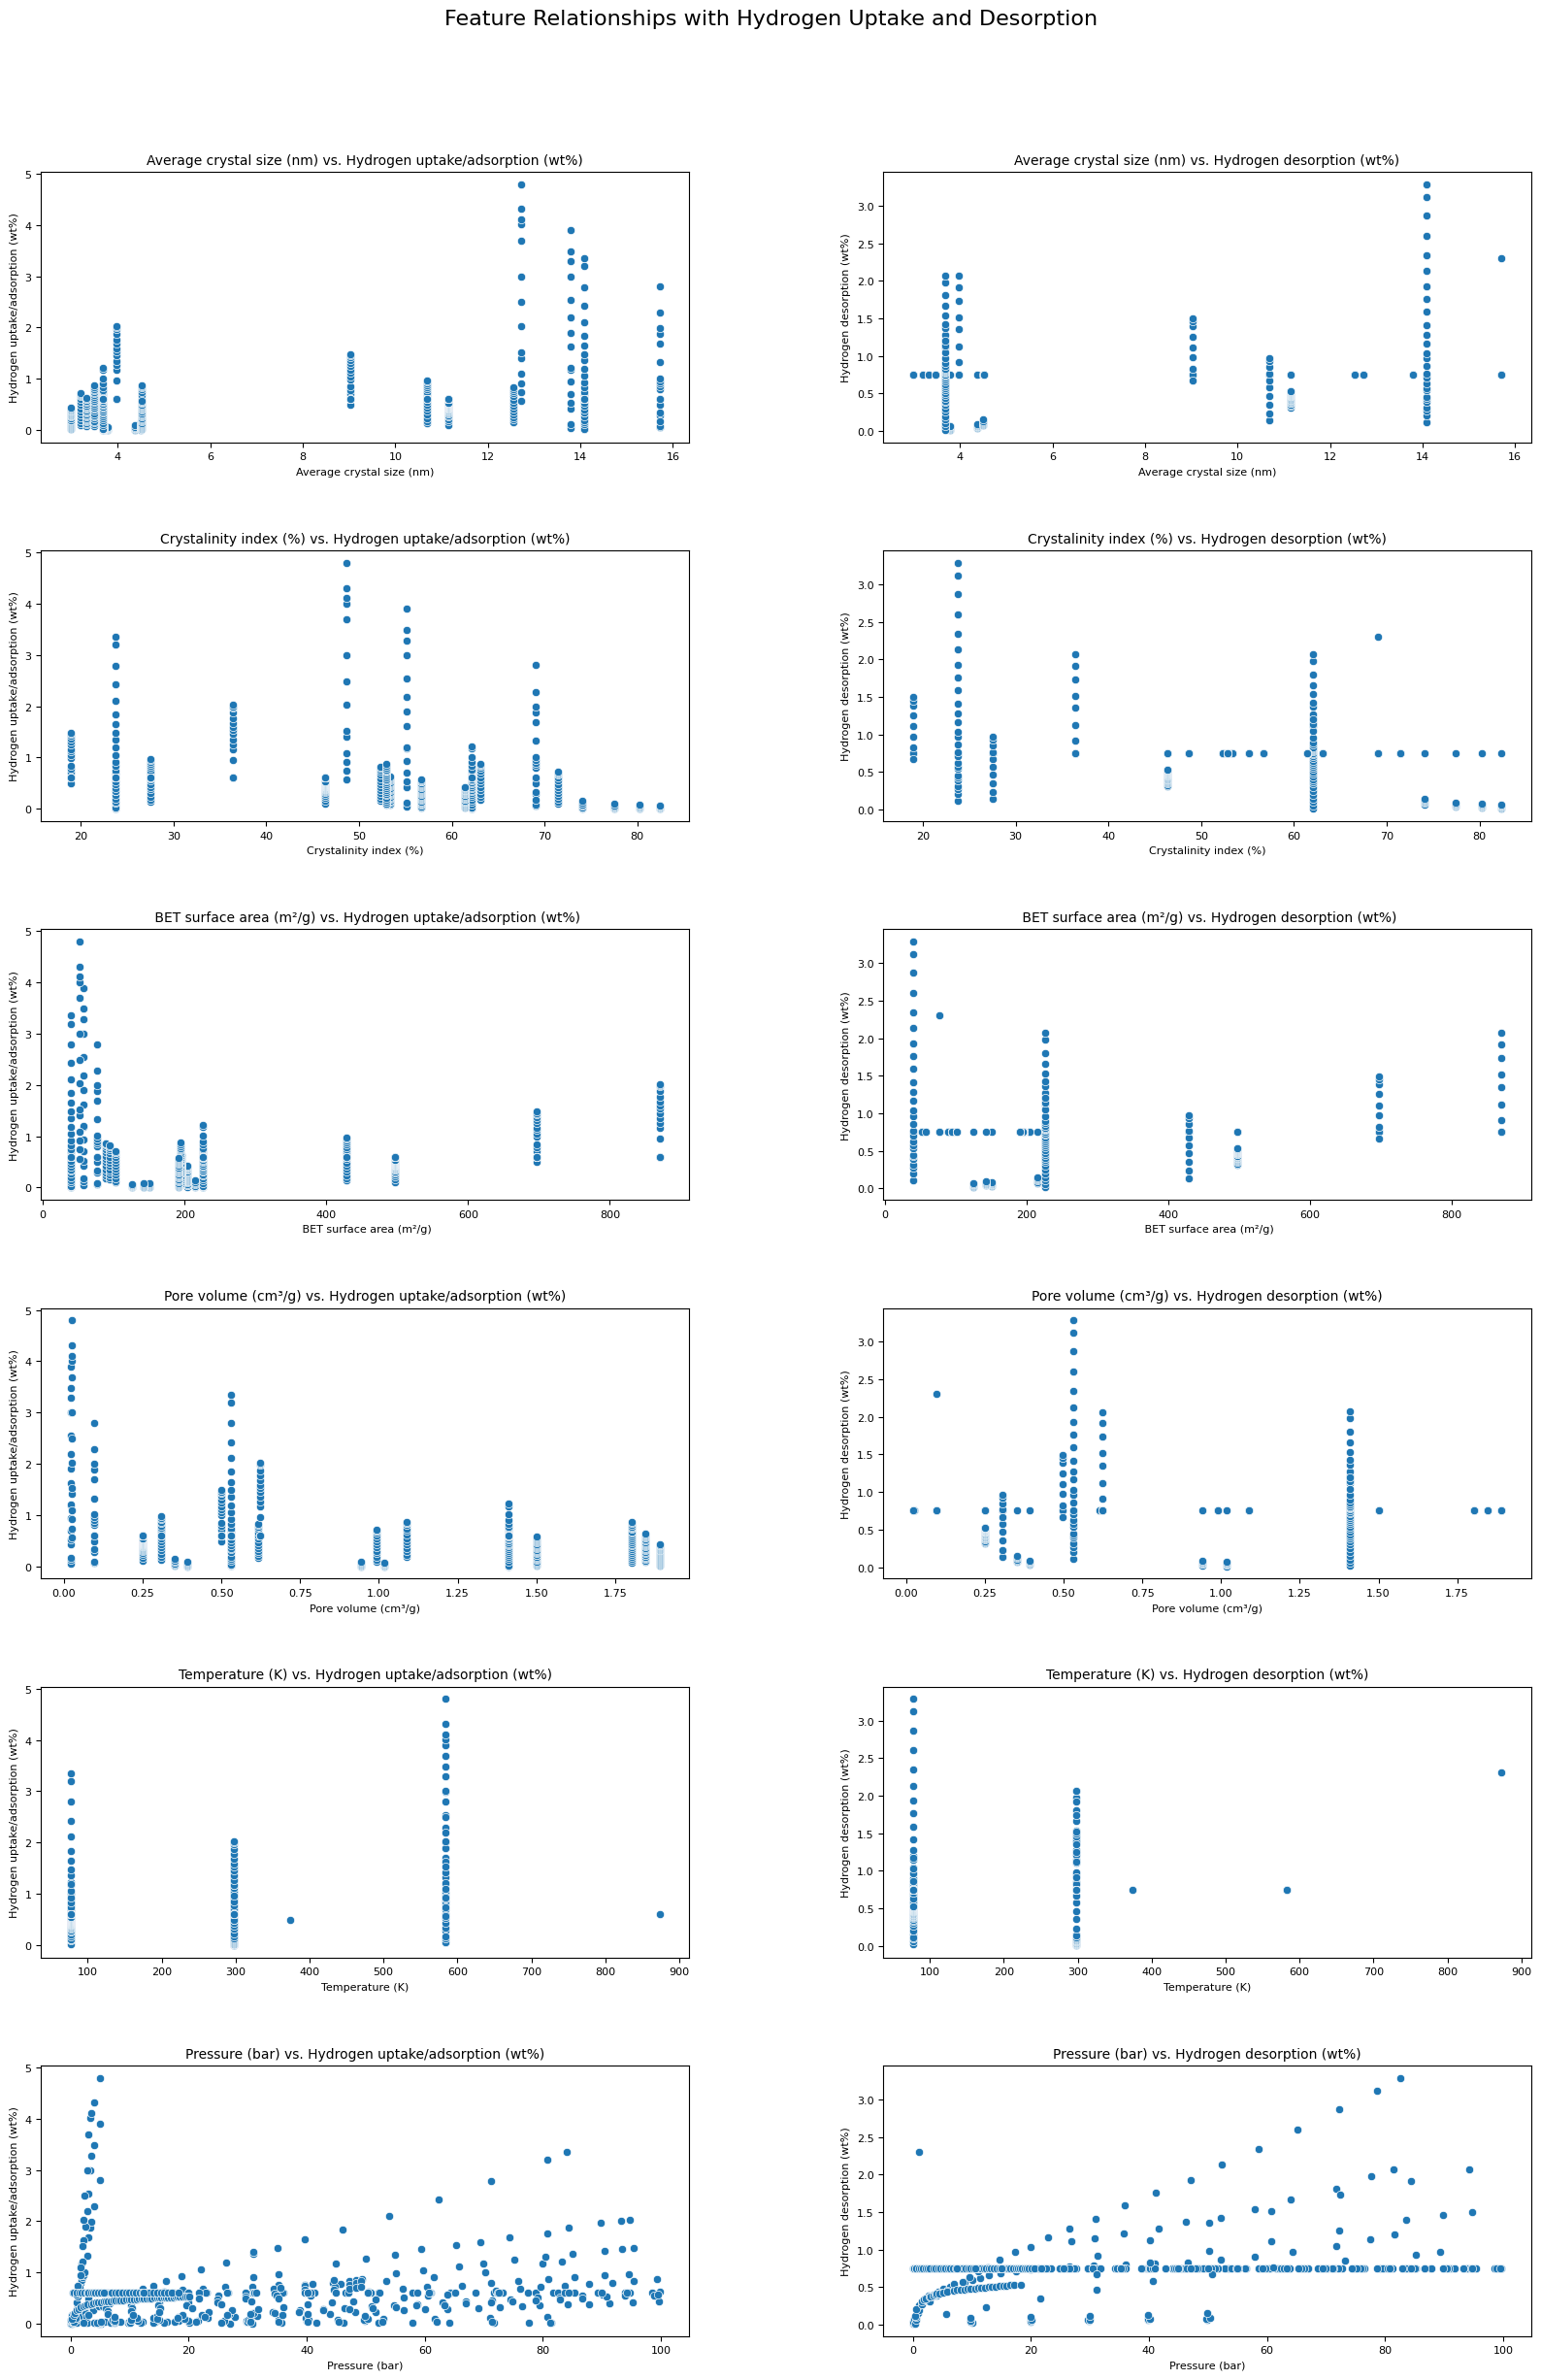

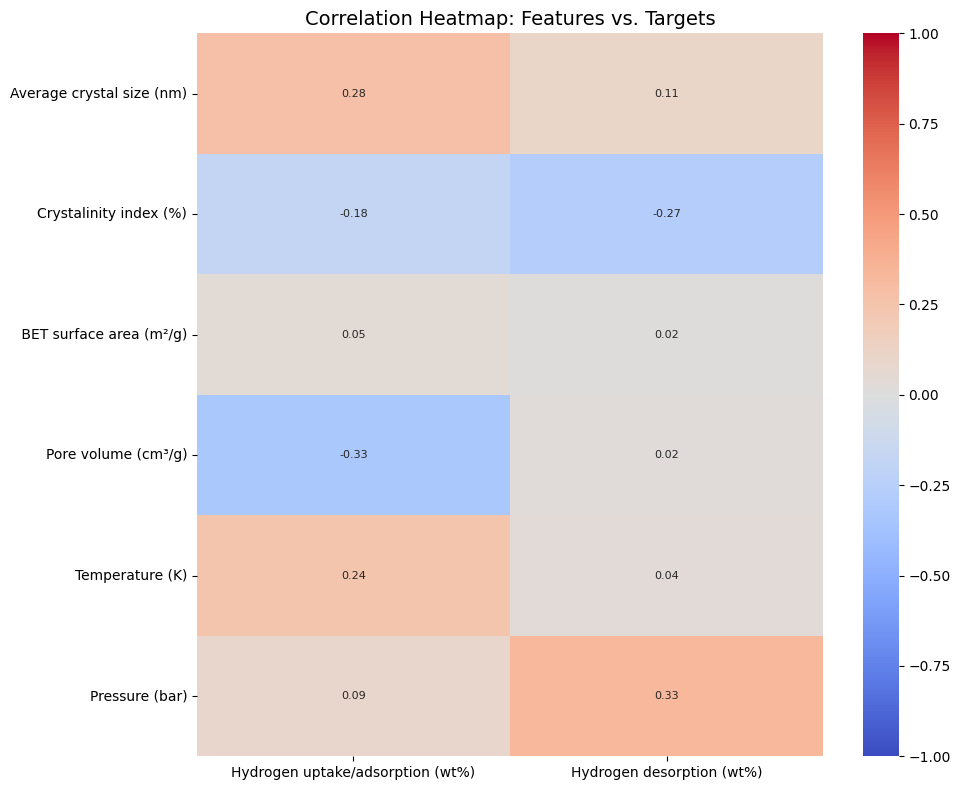

In [ ]:
# Create a list of feature columns
feature_columns = [
    'Average crystal size (nm)',
    'Crystalinity index (%)',
    ' BET surface area (m²/g)',
    'Pore volume (cm³/g)',
    'Temperature (K)',
    'Pressure (bar)'
]

target_columns = [
    'Hydrogen uptake/adsorption (wt%)',
    'Hydrogen desorption (wt%)'
]

# Calculate the number of rows needed for subplots
n_rows = len(feature_columns)
n_cols = len(target_columns)

# Create subplots with adjusted figure size and spacing
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
fig.suptitle('Feature Relationships with Hydrogen Uptake and Desorption', fontsize=16, y=1.02)

# Create scatter plots for each feature-target pair
for i, feature in enumerate(feature_columns):
    for j, target in enumerate(target_columns):
        ax = axes[i, j] if n_rows > 1 else axes[j]
        sns.scatterplot(
            data=df,
            x=feature,
            y=target,
            ax=ax
        )
        ax.set_title(f'{feature} vs. {target}', fontsize=10)
        ax.set_xlabel(feature, fontsize=8)
        ax.set_ylabel(target, fontsize=8)
        ax.tick_params(labelsize=8)

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(top=0.95, hspace=0.4, wspace=0.3)

# Display the figure
plt.show()

# Create a correlation heatmap for features and targets
plt.figure(figsize=(10, 8))
correlation_matrix = df[feature_columns + target_columns].corr().loc[feature_columns, target_columns]
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f', annot_kws={'size': 8})
plt.title('Correlation Heatmap: Features vs. Targets', fontsize=14)
plt.tight_layout()
plt.show()


## **Part 2: Machine Learning Model Development**

**1. Data Preprocessing:**

- Handle any missing values and perform necessary data transformations (normalization or encoding categorical variables).
- Split the dataset into training and testing sets (typically 80/20). You may use cross - validation.

In [ ]:
# Print initial information
print("Initial data shape:", df.shape)
print("\nMissing values:")
print(df.isnull().sum())
print("\nData types:")
print(df.dtypes)


Initial data shape: (539, 9)

Missing values:
Material name                       0
Average crystal size (nm)           0
Crystalinity index (%)              0
 BET surface area (m²/g)            0
Pore volume (cm³/g)                 0
Temperature (K)                     0
Pressure (bar)                      0
Hydrogen uptake/adsorption (wt%)    0
Hydrogen desorption (wt%)           0
dtype: int64

Data types:
Material name                        object
Average crystal size (nm)           float64
Crystalinity index (%)              float64
 BET surface area (m²/g)            float64
Pore volume (cm³/g)                 float64
Temperature (K)                     float64
Pressure (bar)                      float64
Hydrogen uptake/adsorption (wt%)    float64
Hydrogen desorption (wt%)           float64
dtype: object


In [ ]:
# Define feature columns
numerical_columns = [
    'Average crystal size (nm)',
    'Crystalinity index (%)',
    ' BET surface area (m²/g)',
    'Pore volume (cm³/g)',
    'Temperature (K)',
    'Pressure (bar)'
]

categorical_columns = ['Material name']

target_columns = [
    'Hydrogen uptake/adsorption (wt%)',
    'Hydrogen desorption (wt%)'
]

# **Model Selection:**

Choose a suitable machine learning algorithm. Try three different models, Random forest, decision tree and XGBoost.
Implement the model using libraries such as Scikit-learn or TensorFlow.

In [ ]:
models = {
        'Random Forest': RandomForestRegressor(random_state=42),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'XGBoost': XGBRegressor(random_state=42)
    }

# **Training the Model**:

Train your model on the training dataset.
Adjust hyperparameters if necessary to optimize performance.

# **Model Evaluation:**

Evaluate your model using the test dataset.
Use metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and R² score to assess model performance.

# **Feature Importance Analysis:**

Use feature importance techniques (e.g., permutation importance or SHAP values) to determine which input features significantly influence hydrogen storage capacity.
Discuss the implications of your findings.

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance


def train_models(df, numerical_columns, categorical_columns, target_columns, n_folds=5):
    # Create preprocessing pipelines
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns)
        ])

    # Prepare features
    X = df[numerical_columns + categorical_columns]

    # Initialize models
    models = {
        'Random Forest': RandomForestRegressor(random_state=42),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'XGBoost': XGBRegressor(random_state=42)
    }

    # Initialize KFold
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # Train and evaluate models for each target
    results = {}
    for target in target_columns:
        y = df[target]

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        target_results = {}
        for name, model in models.items():
            # Create a pipeline with preprocessor and model
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('regressor', model)
            ])

            # Perform cross-validation
            cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='r2')

            # Fit the pipeline on the entire training set
            pipeline.fit(X_train, y_train)

            # Make predictions on the test set
            y_pred = pipeline.predict(X_test)

            # Calculate metrics
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # Store results
            target_results[name] = {
                'pipeline': pipeline,
                'mse': mse,
                'mae': mae,
                'r2': r2,
                'cv_scores': cv_scores
            }

            # Print results
            print(f"\n{name} Results for {target}:")
            print(f"  Test MSE: {mse:.4f}")
            print(f"  Test MAE: {mae:.4f}")
            print(f"  Test R2 Score: {r2:.4f}")
            print(f"  Cross-validation R2 scores: {cv_scores}")
            print(f"  Mean CV R2 score: {np.mean(cv_scores):.4f}")

            # Feature Importance plot
            if hasattr(pipeline['regressor'], 'feature_importances_'):
                feature_importance = pipeline['regressor'].feature_importances_
                feature_names = pipeline['preprocessor'].get_feature_names_out()
                sorted_idx = feature_importance.argsort()

                fig = go.Figure(go.Bar(
                    x=feature_importance[sorted_idx],
                    y=feature_names[sorted_idx],
                    orientation='h'
                ))
                fig.update_layout(title=f"{name} - Feature Importance for {target}")
                fig.update_layout(height=600, width=1000)
                fig.show()

            # Permutation Importance
            perm_importance = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42)

            # Sort features by importance
            perm_importance_sorted_idx = perm_importance.importances_mean.argsort()

            # Plot Permutation Importance
            fig_perm = go.Figure(go.Bar(
                x=perm_importance.importances_mean[perm_importance_sorted_idx],
                y=feature_names[perm_importance_sorted_idx],
                orientation='h',
                error_x=dict(
                    type='data',
                    array=perm_importance.importances_std[perm_importance_sorted_idx],
                    visible=True
                )
            ))
            fig_perm.update_layout(
                title=f"{name} - Permutation Importance for {target}",
                xaxis_title="Mean accuracy decrease",
                yaxis_title="Feature",
                height=600,
                width=1000
            )
            fig_perm.show()

        results[target] = target_results

    return results

# Run the function
results = train_models(df, numerical_columns, categorical_columns, target_columns)


Random Forest Results for Hydrogen uptake/adsorption (wt%):
  Test MSE: 0.1131
  Test MAE: 0.1623
  Test R2 Score: 0.4079
  Cross-validation R2 scores: [0.40677604 0.79032128 0.57051086 0.79531771 0.77431015]
  Mean CV R2 score: 0.6674



Decision Tree Results for Hydrogen uptake/adsorption (wt%):
  Test MSE: 0.1530
  Test MAE: 0.1884
  Test R2 Score: 0.1991
  Cross-validation R2 scores: [-0.01003651  0.61237268  0.47102638  0.6009028   0.7271022 ]
  Mean CV R2 score: 0.4803



XGBoost Results for Hydrogen uptake/adsorption (wt%):
  Test MSE: 0.1411
  Test MAE: 0.1907
  Test R2 Score: 0.2614
  Cross-validation R2 scores: [0.44582776 0.73276569 0.65846105 0.72343499 0.74079573]
  Mean CV R2 score: 0.6603



Random Forest Results for Hydrogen desorption (wt%):
  Test MSE: 0.1146
  Test MAE: 0.1721
  Test R2 Score: 0.2743
  Cross-validation R2 scores: [ 0.33502166 -0.11599634 -0.64550789  0.23711435  0.32335061]
  Mean CV R2 score: 0.0268



Decision Tree Results for Hydrogen desorption (wt%):
  Test MSE: 0.1328
  Test MAE: 0.1555
  Test R2 Score: 0.1590
  Cross-validation R2 scores: [-0.03446773 -0.6890492  -2.11702563 -0.30295327  0.03670268]
  Mean CV R2 score: -0.6214



XGBoost Results for Hydrogen desorption (wt%):
  Test MSE: 0.1284
  Test MAE: 0.1832
  Test R2 Score: 0.1872
  Cross-validation R2 scores: [ 0.51982227 -0.22632981 -0.26862766  0.14385349  0.23439952]
  Mean CV R2 score: 0.0806


# **Discuss Result**

Based on these results, we can conclude:

1. Optimal Model

- For Hydrogen uptake/adsorption (wt%):
The Random Forest model performs the best, with the highest test R2 score (0.4079) and the highest mean cross-validation R2 score (0.6674). It also has the lowest MSE and MAE.
- For Hydrogen desorption (wt%):
The performance of all models is relatively poor, with low or negative R2 scores. However, the Random Forest model still performs slightly better than the others, with the highest test R2 score (0.2743).

2. Important Feature

a, For Hydrogen uptake/adsorption (wt%):

- Temperature (K) and Pressure (bar) consistently appear as the most important features across all three models.
- Pore volume (cm³/g) is the third most important feature for Random Forest and Decision Tree, but less so for XGBoost.
- BET surface area (m²/g), Average crystal size (nm), and Crystalinity index (%) have relatively low importance across all models.

b, For Hydrogen desorption (wt%):

- Pressure (bar) and Crystalinity index (%) are the top two most important features for the Random Forest model.
- For the Decision Tree model, Crystalinity index (%) is the most important, followed by Pressure (bar).
- Temperature (K) shows moderate importance for hydrogen desorption, especially in the Decision Tree model.
- Pore volume, BET surface area, and Average crystal size show low importance for desorption across models.

